In [14]:
import numpy as np
from collections import Counter
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split


def gini_index(groups, classes):
    n_instances = float(sum([len(group) for group in groups]))
    gini = 0.0
    for group in groups:
        size = float(len(group))
        if size == 0:
            continue
        score = 0.0
        group_labels = [row[-1] for row in group]
        for class_val in classes:
            p = group_labels.count(class_val) / size
            score += p * p
        gini += (1.0 - score) * (size / n_instances)
    return gini


def test_split(index, value, dataset):
    left, right = [], []
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

def get_split(dataset, n_features):
    class_values = list(set(row[-1] for row in dataset))
    features = np.random.choice(len(dataset[0]) - 1, n_features, replace=False)
    best_index, best_value, best_score, best_groups = None, None, float('inf'), None
    for index in features:
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < best_score:
                best_index, best_value, best_score, best_groups = index, row[index], gini, groups
    return {'index': best_index, 'value': best_value, 'groups': best_groups}


def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return Counter(outcomes).most_common(1)[0][0]


def split(node, max_depth, min_size, n_features, depth):
    left, right = node['groups']
    del(node['groups'])

    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return

    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return

    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, n_features)
        split(node['left'], max_depth, min_size, n_features, depth+1)

    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right, n_features)
        split(node['right'], max_depth, min_size, n_features, depth+1)


def build_tree(train, max_depth, min_size, n_features):
    root = get_split(train, n_features)
    split(root, max_depth, min_size, n_features, 1)
    return root


def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']


def subsample(dataset, ratio):
    sample = []
    n_sample = round(len(dataset) * ratio)
    while len(sample) < n_sample:
        index = np.random.randint(len(dataset))
        sample.append(dataset[index])
    return sample


def bagging_predict(trees, row):
    predictions = [predict(tree, row) for tree in trees]
    return Counter(predictions).most_common(1)[0][0]


def random_forest(train, test, max_depth, min_size, sample_size, n_trees, n_features):
    trees = []
    for _ in range(n_trees):
        sample = subsample(train, sample_size)
        tree = build_tree(sample, max_depth, min_size, n_features)
        trees.append(tree)
    predictions = [bagging_predict(trees, row) for row in test]
    return predictions


def accuracy_metric(actual, predicted):
    correct = sum(1 for a, p in zip(actual, predicted) if a == p)
    return correct / len(actual)


iris = load_iris()
X, y = iris.data.tolist(), iris.target.tolist()
dataset = [x + [y_] for x, y_ in zip(X, y)]


train_set, temp_set = train_test_split(dataset, test_size=0.4, random_state=1)
val_set, test_set = train_test_split(temp_set, test_size=0.5, random_state=1)


max_depth = 10
min_size = 1
sample_size = 1.0
n_features = int(np.sqrt(len(train_set[0]) - 1))


tree_counts = [20, 40, 90, 150, 250]

best_acc = 0
best_n = 0
print("Random Forest")
print("Trees | Val Acc | Test Acc")
print("---------------------------")

for n_trees in tree_counts:
    val_preds = random_forest(train_set, val_set, max_depth, min_size, sample_size, n_trees, n_features)
    val_actual = [row[-1] for row in val_set]
    val_acc = accuracy_metric(val_actual, val_preds)

    combined_train = train_set + val_set
    test_preds = random_forest(combined_train, test_set, max_depth, min_size, sample_size, n_trees, n_features)
    test_actual = [row[-1] for row in test_set]
    test_acc = accuracy_metric(test_actual, test_preds)

    print(f"{n_trees:<5} | {val_acc:.4f}  | {test_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_n = n_trees

print("\nBest model: Trees =", best_n, "| Validation Accuracy =", best_acc)


Random Forest
Trees | Val Acc | Test Acc
---------------------------
20    | 0.9333  | 0.9667
40    | 0.9333  | 0.9667
90    | 0.9333  | 0.9667
150   | 0.9333  | 0.9667
250   | 0.9667  | 0.9667

Best model: Trees = 250 | Validation Accuracy = 0.9666666666666667


Intercept (b0): 2.2000
Slope (b1): 0.6000


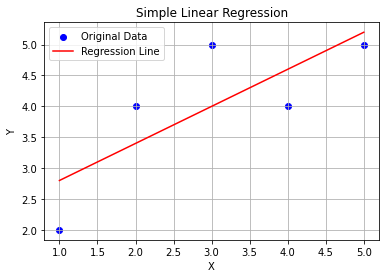

In [15]:
import numpy as np
import matplotlib.pyplot as plt


X = np.array([1, 2, 3, 4, 5], dtype=float)
Y = np.array([2, 4, 5, 4, 5], dtype=float)


def mean(values):
    return sum(values) / float(len(values))


def covariance(x, y, x_mean, y_mean):
    covar = 0.0
    for i in range(len(x)):
        covar += (x[i] - x_mean) * (y[i] - y_mean)
    return covar


def variance(values, mean_val):
    return sum((x - mean_val) ** 2 for x in values)


def coefficients(x, y):
    x_mean, y_mean = mean(x), mean(y)
    b1 = covariance(x, y, x_mean, y_mean) / variance(x, x_mean)
    b0 = y_mean - b1 * x_mean
    return b0, b1


def simple_linear_regression(x, b0, b1):
    return [b0 + b1 * xi for xi in x]


b0, b1 = coefficients(X, Y)
print(f"Intercept (b0): {b0:.4f}")
print(f"Slope (b1): {b1:.4f}")


predicted_Y = simple_linear_regression(X, b0, b1)


plt.scatter(X, Y, color='blue', label='Original Data')
plt.plot(X, predicted_Y, color='red', label='Regression Line')
plt.title('Simple Linear Regression')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()


Model Coefficients: Intercept (b0) = -0.3398, Slope (b1) = 0.4101

Evaluation Results:
Training MSE (Loss): 0.0482
Training R² (Accuracy): 0.9177
Validation MSE (Loss): 0.0206
Validation R² (Accuracy): 0.9578
Testing MSE (Loss): 0.0458
Testing R² (Accuracy): 0.9280


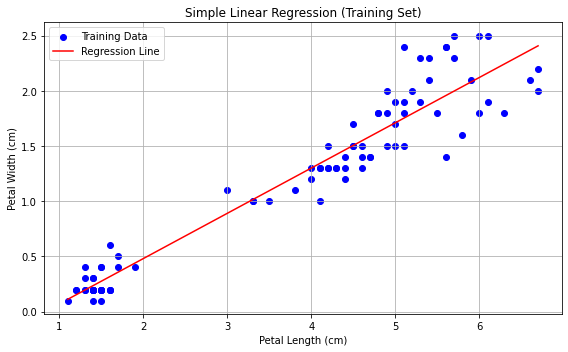

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


iris = load_iris()
X_full = iris.data[:, 2]  
Y_full = iris.data[:, 3]  


X_temp, X_test, Y_temp, Y_test = train_test_split(X_full, Y_full, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


def mean(values):
    return sum(values) / float(len(values))


def covariance(x, y, x_mean, y_mean):
    return sum((x[i] - x_mean) * (y[i] - y_mean) for i in range(len(x)))


def variance(values, mean_val):
    return sum((x - mean_val) ** 2 for x in values)

def coefficients(x, y):
    x_mean, y_mean = mean(x), mean(y)
    b1 = covariance(x, y, x_mean, y_mean) / variance(x, x_mean)
    b0 = y_mean - b1 * x_mean
    return b0, b1

def predict(x, b0, b1):
    return np.array([b0 + b1 * xi for xi in x])

def r2_score_manual(y_true, y_pred):
    mean_y = mean(y_true)
    ss_total = sum((y - mean_y) ** 2 for y in y_true)
    ss_res = sum((y_true[i] - y_pred[i]) ** 2 for i in range(len(y_true)))
    return 1 - (ss_res / ss_total)


b0, b1 = coefficients(X_train, Y_train)
print(f"Model Coefficients: Intercept (b0) = {b0:.4f}, Slope (b1) = {b1:.4f}")


Y_train_pred = predict(X_train, b0, b1)
Y_val_pred = predict(X_val, b0, b1)
Y_test_pred = predict(X_test, b0, b1)

def evaluate(y_true, y_pred, name=""):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} MSE (Loss): {mse:.4f}")
    print(f"{name} R² (Accuracy): {r2:.4f}")
    return mse, r2

print("\nEvaluation Results:")
train_mse, train_r2 = evaluate(Y_train, Y_train_pred, "Training")
val_mse, val_r2 = evaluate(Y_val, Y_val_pred, "Validation")
test_mse, test_r2 = evaluate(Y_test, Y_test_pred, "Testing")

plt.figure(figsize=(8, 5))
plt.scatter(X_train, Y_train, color='blue', label='Training Data')
plt.plot(sorted(X_train), predict(sorted(X_train), b0, b1), color='red', label='Regression Line')
plt.title("Simple Linear Regression (Training Set)")
plt.xlabel("Petal Length (cm)")
plt.ylabel("Petal Width (cm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Model coefficients: Intercept (b0) = -0.6695, Slope (b1) = 0.4487

Evaluation Metrics:
Training MSE (Loss): 0.0712, Accuracy: 0.9222
Validation MSE (Loss): 0.0557, Accuracy: 1.0000
Testing MSE (Loss): 0.0641, Accuracy: 1.0000


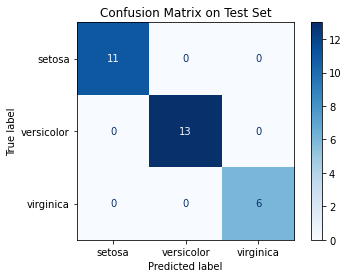

In [17]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

iris = load_iris()
X = iris.data[:, 2]   
y = iris.target        

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


def mean(values):
    return sum(values) / len(values)

def covariance(x, y, x_mean, y_mean):
    return sum((x[i] - x_mean) * (y[i] - y_mean) for i in range(len(x)))

def variance(values, mean_val):
    return sum((x - mean_val) ** 2 for x in values)

def coefficients(x, y):
    x_mean, y_mean = mean(x), mean(y)
    b1 = covariance(x, y, x_mean, y_mean) / variance(x, x_mean)
    b0 = y_mean - b1 * x_mean
    return b0, b1

def predict(x, b0, b1):
    return np.array([b0 + b1 * xi for xi in x])

def round_and_clip(preds):
    return np.clip(np.round(preds), 0, 2).astype(int)


b0, b1 = coefficients(X_train, y_train)
print(f"Model coefficients: Intercept (b0) = {b0:.4f}, Slope (b1) = {b1:.4f}")

y_train_pred_cont = predict(X_train, b0, b1)
y_val_pred_cont = predict(X_val, b0, b1)
y_test_pred_cont = predict(X_test, b0, b1)

y_train_pred = round_and_clip(y_train_pred_cont)
y_val_pred = round_and_clip(y_val_pred_cont)
y_test_pred = round_and_clip(y_test_pred_cont)

train_mse = mean_squared_error(y_train, y_train_pred_cont)
val_mse = mean_squared_error(y_val, y_val_pred_cont)
test_mse = mean_squared_error(y_test, y_test_pred_cont)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\nEvaluation Metrics:")
print(f"Training MSE (Loss): {train_mse:.4f}, Accuracy: {train_acc:.4f}")
print(f"Validation MSE (Loss): {val_mse:.4f}, Accuracy: {val_acc:.4f}")
print(f"Testing MSE (Loss): {test_mse:.4f}, Accuracy: {test_acc:.4f}")

cm = confusion_matrix(y_test, y_test_pred, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()


Dataset sizes:
Train: 90, Validation: 30, Test: 30

Training network with Sigmoid activation:
Running epoch 1/5
Epoch 1/5 - Train loss: 1.1476, Train acc: 0.3333, Val loss: 1.1464, Val acc: 0.3333
Running epoch 2/5
Epoch 2/5 - Train loss: 1.1464, Train acc: 0.3333, Val loss: 1.1452, Val acc: 0.3333
Running epoch 3/5
Epoch 3/5 - Train loss: 1.1452, Train acc: 0.3333, Val loss: 1.1440, Val acc: 0.3333
Running epoch 4/5
Epoch 4/5 - Train loss: 1.1440, Train acc: 0.3333, Val loss: 1.1428, Val acc: 0.3333
Running epoch 5/5
Epoch 5/5 - Train loss: 1.1428, Train acc: 0.3333, Val loss: 1.1417, Val acc: 0.3333

Sigmoid Test accuracy: 0.3333
Sigmoid Test F1 Score: 0.1667
Sigmoid Test Loss: 1.1417

Training network with ReLU activation:
Running epoch 1/5
Epoch 1/5 - Train loss: 3.0671, Train acc: 0.3333, Val loss: 1.6565, Val acc: 0.3333
Running epoch 2/5
Epoch 2/5 - Train loss: 1.7135, Train acc: 0.3333, Val loss: 1.3627, Val acc: 0.3333
Running epoch 3/5
Epoch 3/5 - Train loss: 1.3954, Train ac

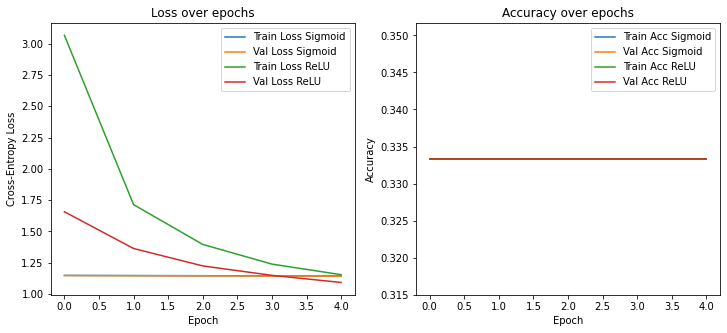

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True)) 
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

def compute_accuracy(y_true_labels, y_pred_labels):
    return accuracy_score(y_true_labels, y_pred_labels)

def compute_f1(y_true_labels, y_pred_labels):
    return f1_score(y_true_labels, y_pred_labels, average='macro')

class DeepNeuralNetwork:
    def __init__(self, layer_sizes, activation='sigmoid', learning_rate=0.01, seed=42):
        np.random.seed(seed)
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.activation_name = activation
  
        self.weights = []
        self.biases = []
        for i in range(len(layer_sizes) - 1):
            input_dim = layer_sizes[i]
            output_dim = layer_sizes[i + 1]
            if activation == 'sigmoid':
                limit = np.sqrt(6 / (input_dim + output_dim))
                W = np.random.uniform(-limit, limit, (input_dim, output_dim))
            elif activation == 'relu':
                std = np.sqrt(2 / input_dim)
                W = np.random.randn(input_dim, output_dim) * std
            else:
                raise ValueError("Activation must be 'sigmoid' or 'relu'")
            b = np.zeros((1, output_dim))
            self.weights.append(W)
            self.biases.append(b)
    
    def activation(self, z):
        if self.activation_name == 'sigmoid':
            return sigmoid(z)
        elif self.activation_name == 'relu':
            return relu(z)
        else:
            raise ValueError("Activation must be 'sigmoid' or 'relu'")
    
    def activation_derivative(self, z):
        if self.activation_name == 'sigmoid':
            return sigmoid_derivative(z)
        elif self.activation_name == 'relu':
            return relu_derivative(z)
        else:
            raise ValueError("Activation must be 'sigmoid' or 'relu'")
    
    def forward(self, X):
        self.zs = []
        self.activations = [X]
        
        for i in range(len(self.weights) - 1):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.zs.append(z)
            a = self.activation(z)
            self.activations.append(a)
   
        z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        a = softmax(z)
        self.activations.append(a)
        
        return a
    
    def backward(self, X, y_true):
        m = X.shape[0]
        grads_w = [0] * len(self.weights)
        grads_b = [0] * len(self.biases)
  
        delta = self.activations[-1] - y_true  
  
        grads_w[-1] = np.dot(self.activations[-2].T, delta) / m
        grads_b[-1] = np.sum(delta, axis=0, keepdims=True) / m
        
        for l in range(len(self.weights) - 2, -1, -1):
            dz = np.dot(delta, self.weights[l + 1].T) * self.activation_derivative(self.zs[l])
            grads_w[l] = np.dot(self.activations[l].T, dz) / m
            grads_b[l] = np.sum(dz, axis=0, keepdims=True) / m
            delta = dz
     
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads_w[i]
            self.biases[i] -= self.learning_rate * grads_b[i]
    
    def train(self, X_train, y_train, X_val, y_val, epochs=100):
        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
        
        for epoch in range(epochs):
            print(f"Running epoch {epoch+1}/{epochs}")  
            
            y_pred_train = self.forward(X_train)
            loss_train = cross_entropy_loss(y_train, y_pred_train)
            pred_train_labels = np.argmax(y_pred_train, axis=1)
            true_train_labels = np.argmax(y_train, axis=1)
            acc_train = compute_accuracy(true_train_labels, pred_train_labels)
         
            self.backward(X_train, y_train)
       
            y_pred_val = self.forward(X_val)
            loss_val = cross_entropy_loss(y_val, y_pred_val)
            pred_val_labels = np.argmax(y_pred_val, axis=1)
            true_val_labels = np.argmax(y_val, axis=1)
            acc_val = compute_accuracy(true_val_labels, pred_val_labels)
    
            history['train_loss'].append(loss_train)
            history['val_loss'].append(loss_val)
            history['train_acc'].append(acc_train)
            history['val_acc'].append(acc_val)
            
        
            print(f"Epoch {epoch+1}/{epochs} - Train loss: {loss_train:.4f}, Train acc: {acc_train:.4f}, Val loss: {loss_val:.4f}, Val acc: {acc_val:.4f}")
        
        return history
    
    def predict(self, X):
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)



iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)

encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y)

X_temp, X_test, y_temp, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print("Dataset sizes:")
print(f"Train: {X_train.shape[0]}, Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")

input_size = X_train.shape[1]
output_size = y_train.shape[1]
hidden_layers = 6
hidden_units = 10

layer_sizes = [input_size] + [hidden_units]*hidden_layers + [output_size]

epochs = 5
learning_rate = 0.01

print("\nTraining network with Sigmoid activation:")
nn_sigmoid = DeepNeuralNetwork(layer_sizes, activation='sigmoid', learning_rate=learning_rate)
history_sigmoid = nn_sigmoid.train(X_train, y_train, X_val, y_val, epochs=epochs)

y_test_pred_sigmoid = nn_sigmoid.predict(X_test)
y_test_true_labels = np.argmax(y_test, axis=1)
test_acc_sigmoid = compute_accuracy(y_test_true_labels, y_test_pred_sigmoid)
test_f1_sigmoid = compute_f1(y_test_true_labels, y_test_pred_sigmoid)
test_loss_sigmoid = cross_entropy_loss(y_test, nn_sigmoid.forward(X_test))

print(f"\nSigmoid Test accuracy: {test_acc_sigmoid:.4f}")
print(f"Sigmoid Test F1 Score: {test_f1_sigmoid:.4f}")
print(f"Sigmoid Test Loss: {test_loss_sigmoid:.4f}")

print("\nTraining network with ReLU activation:")
nn_relu = DeepNeuralNetwork(layer_sizes, activation='relu', learning_rate=learning_rate)
history_relu = nn_relu.train(X_train, y_train, X_val, y_val, epochs=epochs)

y_test_pred_relu = nn_relu.predict(X_test)
test_acc_relu = compute_accuracy(y_test_true_labels, y_test_pred_relu)
test_f1_relu = compute_f1(y_test_true_labels, y_test_pred_relu)
test_loss_relu = cross_entropy_loss(y_test, nn_relu.forward(X_test))

print(f"\nReLU Test accuracy: {test_acc_relu:.4f}")
print(f"ReLU Test F1 Score: {test_f1_relu:.4f}")
print(f"ReLU Test Loss: {test_loss_relu:.4f}")


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_sigmoid['train_loss'], label='Train Loss Sigmoid')
plt.plot(history_sigmoid['val_loss'], label='Val Loss Sigmoid')
plt.plot(history_relu['train_loss'], label='Train Loss ReLU')
plt.plot(history_relu['val_loss'], label='Val Loss ReLU')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_sigmoid['train_acc'], label='Train Acc Sigmoid')
plt.plot(history_sigmoid['val_acc'], label='Val Acc Sigmoid')
plt.plot(history_relu['train_acc'], label='Train Acc ReLU')
plt.plot(history_relu['val_acc'], label='Val Acc ReLU')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Dataset sizes:
Train: 90, Validation: 30, Test: 30


Training for 5 epochs

Sigmoid activation:
Epoch 1/5 - Train loss: 1.1476, Train acc: 0.3333, Val loss: 1.1464, Val acc: 0.3333
Epoch 2/5 - Train loss: 1.1464, Train acc: 0.3333, Val loss: 1.1452, Val acc: 0.3333
Epoch 3/5 - Train loss: 1.1452, Train acc: 0.3333, Val loss: 1.1440, Val acc: 0.3333
Epoch 4/5 - Train loss: 1.1440, Train acc: 0.3333, Val loss: 1.1428, Val acc: 0.3333
Epoch 5/5 - Train loss: 1.1428, Train acc: 0.3333, Val loss: 1.1417, Val acc: 0.3333
Sigmoid Test accuracy: 0.3333
Sigmoid Test F1 Score: 0.1667
Sigmoid Test Loss: 1.1417

ReLU activation:
Epoch 1/5 - Train loss: 3.0671, Train acc: 0.3333, Val loss: 1.6565, Val acc: 0.3333
Epoch 2/5 - Train loss: 1.7135, Train acc: 0.3333, Val loss: 1.3627, Val acc: 0.3333
Epoch 3/5 - Train loss: 1.3954, Train acc: 0.3333, Val loss: 1.2234, Val acc: 0.3333
Epoch 4/5 - Train loss: 1.2381, Train acc: 0.3333, Val loss: 1.1481, Val acc: 0.3333
Epoch 5/5 - Train loss: 1.1534, Tra

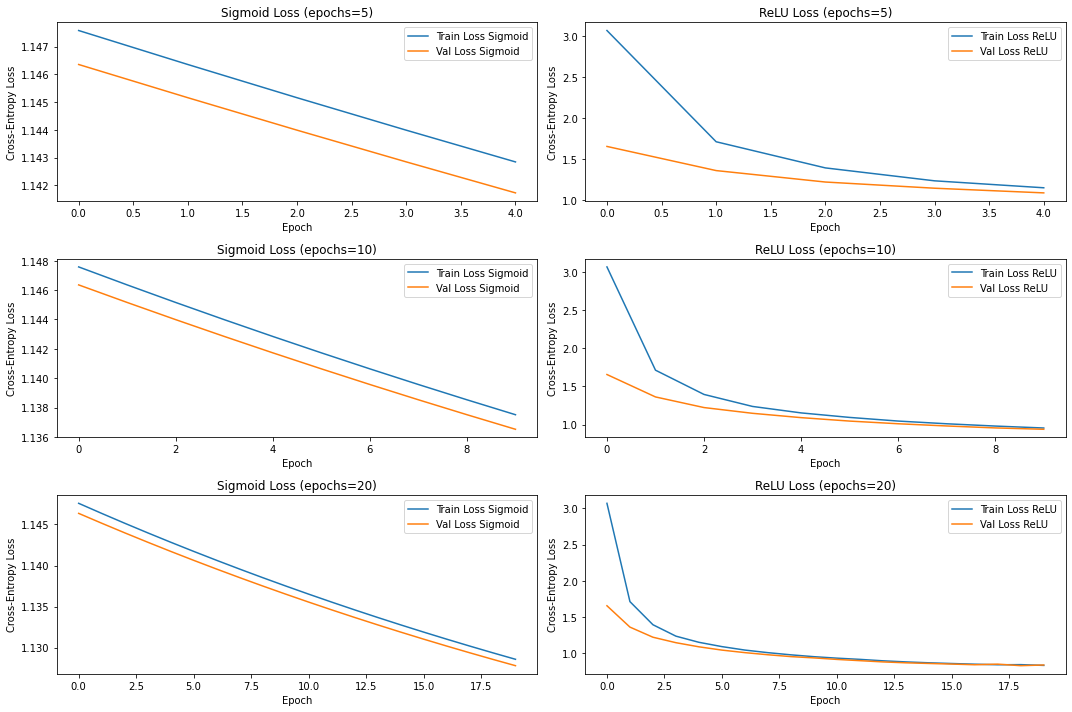

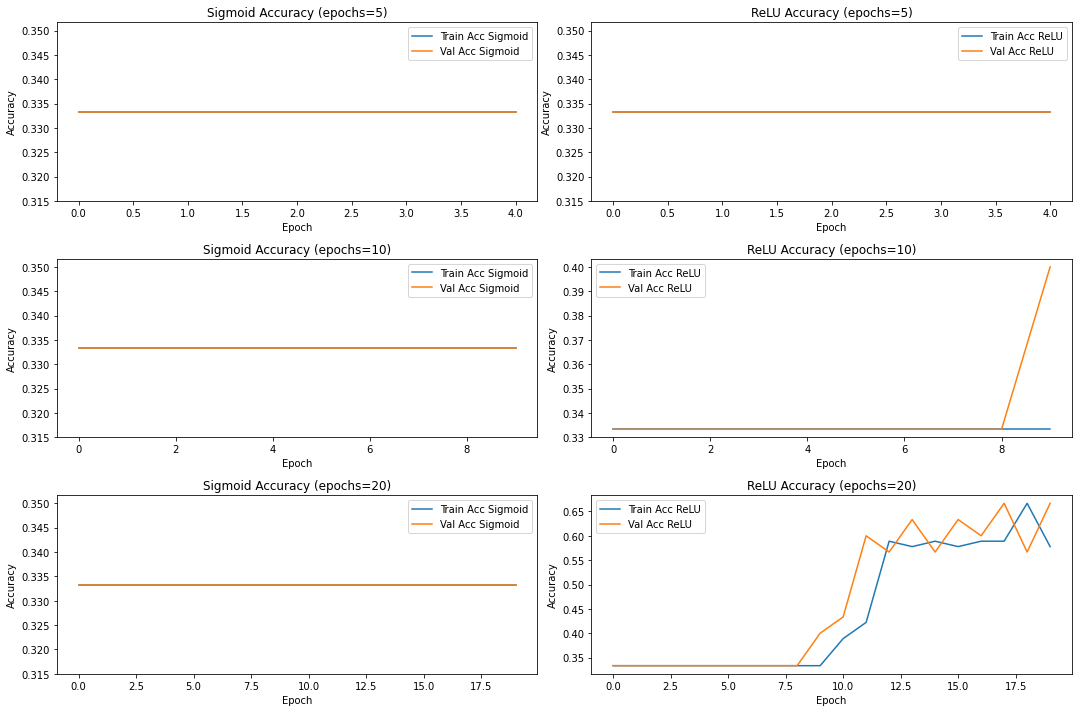

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True)) 
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

def compute_accuracy(y_true_labels, y_pred_labels):
    return accuracy_score(y_true_labels, y_pred_labels)

def compute_f1(y_true_labels, y_pred_labels):
    return f1_score(y_true_labels, y_pred_labels, average='macro')

class DeepNeuralNetwork:
    def __init__(self, layer_sizes, activation='sigmoid', learning_rate=0.01, seed=42):
        np.random.seed(seed)
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.activation_name = activation
  
        self.weights = []
        self.biases = []
        for i in range(len(layer_sizes) - 1):
            input_dim = layer_sizes[i]
            output_dim = layer_sizes[i + 1]
            if activation == 'sigmoid':
                limit = np.sqrt(6 / (input_dim + output_dim))
                W = np.random.uniform(-limit, limit, (input_dim, output_dim))
            elif activation == 'relu':
                std = np.sqrt(2 / input_dim)
                W = np.random.randn(input_dim, output_dim) * std
            else:
                raise ValueError("Activation must be 'sigmoid' or 'relu'")
            b = np.zeros((1, output_dim))
            self.weights.append(W)
            self.biases.append(b)
    
    def activation(self, z):
        if self.activation_name == 'sigmoid':
            return sigmoid(z)
        elif self.activation_name == 'relu':
            return relu(z)
        else:
            raise ValueError("Activation must be 'sigmoid' or 'relu'")
    
    def activation_derivative(self, z):
        if self.activation_name == 'sigmoid':
            return sigmoid_derivative(z)
        elif self.activation_name == 'relu':
            return relu_derivative(z)
        else:
            raise ValueError("Activation must be 'sigmoid' or 'relu'")
    
    def forward(self, X):
        self.zs = []
        self.activations = [X]
        
        for i in range(len(self.weights) - 1):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.zs.append(z)
            a = self.activation(z)
            self.activations.append(a)
   
        z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        a = softmax(z)
        self.activations.append(a)
        
        return a
    
    def backward(self, X, y_true):
        m = X.shape[0]
        grads_w = [0] * len(self.weights)
        grads_b = [0] * len(self.biases)
  
        delta = self.activations[-1] - y_true  
  
        grads_w[-1] = np.dot(self.activations[-2].T, delta) / m
        grads_b[-1] = np.sum(delta, axis=0, keepdims=True) / m
        
        for l in range(len(self.weights) - 2, -1, -1):
            dz = np.dot(delta, self.weights[l + 1].T) * self.activation_derivative(self.zs[l])
            grads_w[l] = np.dot(self.activations[l].T, dz) / m
            grads_b[l] = np.sum(dz, axis=0, keepdims=True) / m
            delta = dz
     
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads_w[i]
            self.biases[i] -= self.learning_rate * grads_b[i]
    
    def train(self, X_train, y_train, X_val, y_val, epochs=100):
        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
        
        for epoch in range(epochs):
   
            y_pred_train = self.forward(X_train)
            loss_train = cross_entropy_loss(y_train, y_pred_train)
            pred_train_labels = np.argmax(y_pred_train, axis=1)
            true_train_labels = np.argmax(y_train, axis=1)
            acc_train = compute_accuracy(true_train_labels, pred_train_labels)
         
            self.backward(X_train, y_train)
 
            y_pred_val = self.forward(X_val)
            loss_val = cross_entropy_loss(y_val, y_pred_val)
            pred_val_labels = np.argmax(y_pred_val, axis=1)
            true_val_labels = np.argmax(y_val, axis=1)
            acc_val = compute_accuracy(true_val_labels, pred_val_labels)
    
            history['train_loss'].append(loss_train)
            history['val_loss'].append(loss_val)
            history['train_acc'].append(acc_train)
            history['val_acc'].append(acc_val)
            
            print(f"Epoch {epoch+1}/{epochs} - Train loss: {loss_train:.4f}, Train acc: {acc_train:.4f}, Val loss: {loss_val:.4f}, Val acc: {acc_val:.4f}")
        
        return history
    
    def predict(self, X):
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)


# Load and preprocess dataset
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)

encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y)

X_temp, X_test, y_temp, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print("Dataset sizes:")
print(f"Train: {X_train.shape[0]}, Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")

input_size = X_train.shape[1]
output_size = y_train.shape[1]
hidden_layers = 6
hidden_units = 10

layer_sizes = [input_size] + [hidden_units]*hidden_layers + [output_size]

learning_rate = 0.01
epoch_list = [5, 10, 20]

y_test_true_labels = np.argmax(y_test, axis=1)

results = {}

for epochs in epoch_list:
    print(f"\n\nTraining for {epochs} epochs")

    print("\nSigmoid activation:")
    nn_sigmoid = DeepNeuralNetwork(layer_sizes, activation='sigmoid', learning_rate=learning_rate)
    history_sigmoid = nn_sigmoid.train(X_train, y_train, X_val, y_val, epochs=epochs)

    y_test_pred_sigmoid = nn_sigmoid.predict(X_test)
    test_acc_sigmoid = compute_accuracy(y_test_true_labels, y_test_pred_sigmoid)
    test_f1_sigmoid = compute_f1(y_test_true_labels, y_test_pred_sigmoid)
    test_loss_sigmoid = cross_entropy_loss(y_test, nn_sigmoid.forward(X_test))

    print(f"Sigmoid Test accuracy: {test_acc_sigmoid:.4f}")
    print(f"Sigmoid Test F1 Score: {test_f1_sigmoid:.4f}")
    print(f"Sigmoid Test Loss: {test_loss_sigmoid:.4f}")

    print("\nReLU activation:")
    nn_relu = DeepNeuralNetwork(layer_sizes, activation='relu', learning_rate=learning_rate)
    history_relu = nn_relu.train(X_train, y_train, X_val, y_val, epochs=epochs)

    y_test_pred_relu = nn_relu.predict(X_test)
    test_acc_relu = compute_accuracy(y_test_true_labels, y_test_pred_relu)
    test_f1_relu = compute_f1(y_test_true_labels, y_test_pred_relu)
    test_loss_relu = cross_entropy_loss(y_test, nn_relu.forward(X_test))

    print(f"ReLU Test accuracy: {test_acc_relu:.4f}")
    print(f"ReLU Test F1 Score: {test_f1_relu:.4f}")
    print(f"ReLU Test Loss: {test_loss_relu:.4f}")

    results[epochs] = {
        'sigmoid': {
            'history': history_sigmoid,
            'test_acc': test_acc_sigmoid,
            'test_f1': test_f1_sigmoid,
            'test_loss': test_loss_sigmoid,
        },
        'relu': {
            'history': history_relu,
            'test_acc': test_acc_relu,
            'test_f1': test_f1_relu,
            'test_loss': test_loss_relu,
        }
    }

# Optional: Plot loss and accuracy for all epoch counts for both activations

plt.figure(figsize=(15, 10))
for i, epochs in enumerate(epoch_list, 1):
    plt.subplot(3, 2, 2*i-1)
    plt.plot(results[epochs]['sigmoid']['history']['train_loss'], label='Train Loss Sigmoid')
    plt.plot(results[epochs]['sigmoid']['history']['val_loss'], label='Val Loss Sigmoid')
    plt.title(f'Sigmoid Loss (epochs={epochs})')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend()

    plt.subplot(3, 2, 2*i)
    plt.plot(results[epochs]['relu']['history']['train_loss'], label='Train Loss ReLU')
    plt.plot(results[epochs]['relu']['history']['val_loss'], label='Val Loss ReLU')
    plt.title(f'ReLU Loss (epochs={epochs})')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, epochs in enumerate(epoch_list, 1):
    plt.subplot(3, 2, 2*i-1)
    plt.plot(results[epochs]['sigmoid']['history']['train_acc'], label='Train Acc Sigmoid')
    plt.plot(results[epochs]['sigmoid']['history']['val_acc'], label='Val Acc Sigmoid')
    plt.title(f'Sigmoid Accuracy (epochs={epochs})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(3, 2, 2*i)
    plt.plot(results[epochs]['relu']['history']['train_acc'], label='Train Acc ReLU')
    plt.plot(results[epochs]['relu']['history']['val_acc'], label='Val Acc ReLU')
    plt.title(f'ReLU Accuracy (epochs={epochs})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()
